In [1]:
import pandas as pd
import numpy as np
import os
import random
from tqdm import tqdm
tqdm.pandas()
from sklearn.utils import shuffle
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from collections import Counter
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import sklearn.metrics as metrics
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('Reddit_Data.csv')
df

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1
...,...,...
37244,jesus,0
37245,kya bhai pure saal chutiya banaya modi aur jab...,1
37246,downvote karna tha par upvote hogaya,0
37247,haha nice,1


In [3]:
df.category.value_counts()

 1    15830
 0    13142
-1     8277
Name: category, dtype: int64

In [4]:
df2 = df[df['category'].isin([-1,1])]
df2

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
4,for your own benefit you may want read living ...,1
5,you should all sit down together and watch the...,-1
...,...,...
37236,fan modi but some the best people ever met li...,1
37240,nice same shock laga effect the night demoneti...,1
37243,this agree why push make other nations either ...,-1
37245,kya bhai pure saal chutiya banaya modi aur jab...,1


In [5]:
df2.category.value_counts()

 1    15830
-1     8277
Name: category, dtype: int64

In [6]:
# balance label dataset
n_drop_rows = df2.category.value_counts()[1] - df2.category.value_counts()[-1]
positive_selected_index = random.sample(list(df2[df2['category']==1].index), n_drop_rows)
df2 = df2[~df2.index.isin(positive_selected_index)]
df2.category.value_counts()

 1    8277
-1    8277
Name: category, dtype: int64

In [7]:
# Select English stop
import string
stop = stopwords.words('english')
StopWords = set(stopwords.words('english'))
wn = WordNetLemmatizer()

def useful(token):
    return  token not in StopWords and token not in list(string.punctuation)  and len(token)>2 

# clean data  
def clean_txt(text):
    clean_text = []
    clean_text2 = []
    clean_text3 = []
    clean_text = [wn.lemmatize(word, pos="v") for word in word_tokenize(text.lower()) if useful(word)]
    clean_text2 = [word for word in clean_text if useful(word)]
    return " ".join(clean_text2)
df2['clean_comment'] = df2['clean_comment'].progress_apply(clean_txt)
df2_cleaned = df2
df2_cleaned

100%|██████████████████████████████████████████████████████████████████████████| 16554/16554 [00:07<00:00, 2190.83it/s]


,clean_comment,category
0,family mormon never try explain still stare pu...,1
2,seriously say thing first get complex explain ...,-1
4,benefit may want read live buddha live christ ...,1
5,sit together watch simpsons episode lisa becom...,-1
8,two varieties christians dogmatic dwell word c...,-1
...,...,...
37230,nice try,1
37233,part series minute videos focus different para...,1
37240,nice shock laga effect night demonetization,1
37243,agree push make nations either pity pakistan i...,-1


In [8]:
# Select the top 50 words that are repeated the most in the comment
all_words = ""
for s in df2_cleaned[df2_cleaned['category']==1]['clean_comment']:
    all_words = all_words+" "+s 
    
common_words_positive = Counter(all_words.split()).most_common()
print(common_words_positive[:50])

[('people', 1800), ('india', 1764), ('like', 1661), ('get', 1592), ('good', 1578), ('bjp', 1517), ('modi', 1503), ('make', 1275), ('say', 1242), ('one', 1227), ('would', 1140), ('think', 1120), ('even', 1000), ('time', 941), ('see', 910), ('right', 892), ('know', 869), ('also', 793), ('party', 772), ('take', 770), ('come', 715), ('indian', 706), ('want', 705), ('congress', 700), ('much', 688), ('use', 686), ('give', 668), ('government', 666), ('need', 664), ('really', 663), ('country', 632), ('many', 625), ('vote', 616), ('state', 613), ('work', 601), ('well', 594), ('way', 588), ('best', 573), ('look', 540), ('post', 533), ('better', 527), ('free', 522), ('new', 497), ('years', 471), ('win', 465), ('media', 462), ('team', 460), ('try', 455), ('still', 452), ('first', 448)]


In [9]:
# Select the top 50 words that are repeated the most in the comment
all_words = ""
for s in df2_cleaned[df2_cleaned['category']==-1]['clean_comment']:
    all_words = all_words+" "+s 
    
common_words_negative = Counter(all_words.split()).most_common()
print(common_words_negative[:50])

[('people', 1578), ('bjp', 1530), ('like', 1373), ('india', 1347), ('get', 1342), ('modi', 1320), ('fuck', 1292), ('say', 1179), ('one', 981), ('make', 877), ('think', 839), ('even', 830), ('would', 787), ('time', 743), ('know', 714), ('see', 698), ('congress', 672), ('take', 665), ('party', 664), ('shit', 646), ('government', 625), ('come', 603), ('indian', 584), ('country', 562), ('vote', 557), ('give', 552), ('bad', 550), ('also', 544), ('use', 493), ('state', 486), ('media', 486), ('want', 484), ('need', 480), ('hate', 459), ('guy', 441), ('look', 435), ('way', 427), ('news', 427), ('mean', 419), ('happen', 404), ('post', 398), ('pakistan', 393), ('try', 390), ('thing', 383), ('right', 383), ('work', 381), ('still', 376), ('much', 369), ('years', 362), ('wrong', 360)]


In [10]:
positive_top = [word for word, _ in common_words_positive[:100]]
negative_top = [word for word, _ in common_words_negative[:100]]

add_stop_words = list(set(positive_top) & set(negative_top))
add_stop_words

['would',
 'get',
 'people',
 'lot',
 'indian',
 'could',
 'vote',
 'good',
 'much',
 'congress',
 'support',
 'work',
 'know',
 'bjp',
 'look',
 'want',
 'party',
 'state',
 'money',
 'call',
 'become',
 'still',
 'country',
 'something',
 'say',
 'change',
 'day',
 'power',
 'issue',
 'like',
 'let',
 'years',
 'start',
 'need',
 'point',
 'happen',
 'even',
 'well',
 'question',
 'man',
 'news',
 'see',
 'try',
 'hindu',
 'india',
 'long',
 'minister',
 'thing',
 'time',
 'ask',
 'every',
 'post',
 'feel',
 'political',
 'think',
 'live',
 'talk',
 'one',
 'take',
 'back',
 'keep',
 'right',
 'things',
 'give',
 'modi',
 'come',
 'government',
 'read',
 'make',
 'mean',
 'pakistan',
 'really',
 'find',
 'use',
 'someone',
 'way',
 'never',
 'guy',
 'show',
 'also',
 'media']

In [11]:
# For words that are repeated more than 1800 times and we think this is a useless word, choose to delete

StopWords = set(stopwords.words('english')).union(add_stop_words)
df2_cleaned['clean_comment'] = df2_cleaned['clean_comment'].progress_apply(clean_txt)
comment_final = df2_cleaned
comment_final

100%|██████████████████████████████████████████████████████████████████████████| 16554/16554 [00:06<00:00, 2741.10it/s]


,clean_comment,category
0,family mormon explain stare puzzle kind strang...,1
2,seriously first complex explain normal anyway ...,-1
4,benefit may buddha christ thich nhat hanh migh...,1
5,sit together watch simpsons episode lisa buddh...,-1
8,two varieties christians dogmatic dwell word c...,-1
...,...,...
37230,nice,1
37233,part series minute videos focus different para...,1
37240,nice shock laga effect night demonetization,1
37243,agree push nations either pity course durbuddh...,-1


In [12]:
# get only English word by removing other languages and numbers
words = set(nltk.corpus.words.words())
def English_word(token):
    return token in words and token.isalpha()
def get_English(text):
    return " ".join(w for w in nltk.wordpunct_tokenize(text) if English_word(w))
comment_final['clean_comment'] = comment_final['clean_comment'].progress_apply(get_English)
comment_final

100%|█████████████████████████████████████████████████████████████████████████| 16554/16554 [00:00<00:00, 55657.72it/s]


,clean_comment,category
0,family mormon explain stare puzzle kind strang...,1
2,seriously first complex explain normal anyway ...,-1
4,benefit may might subsequent love easier able ...,1
5,sit together watch episode season episode litt...,-1
8,two dogmatic dwell word conservative heart spi...,-1
...,...,...
37230,nice,1
37233,part series minute focus different please pres...,1
37240,nice shock effect night demonetization,1
37243,agree push either pity course punish send hell,-1


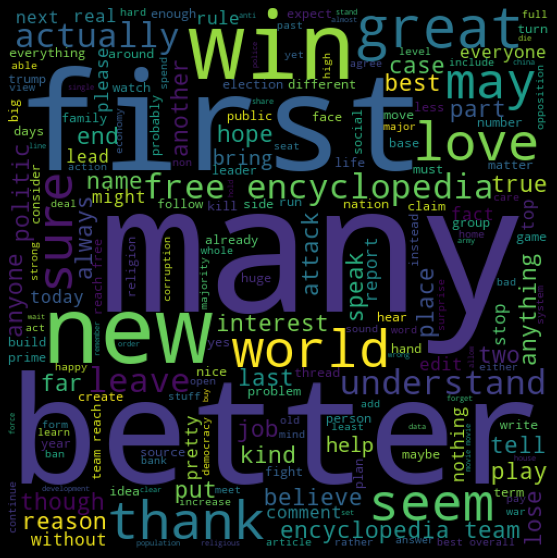

In [13]:
# Draw a comment image to show words with a high number of repetitions
comment_corpus = ' '.join(list(comment_final[comment_final['category'] == 1]['clean_comment']))
comment_wc = WordCloud(width = 500,height = 500).generate(comment_corpus)
plt.figure(figsize = (10, 10), facecolor = 'k')
plt.imshow(comment_wc)
plt.axis('off')
plt.show()

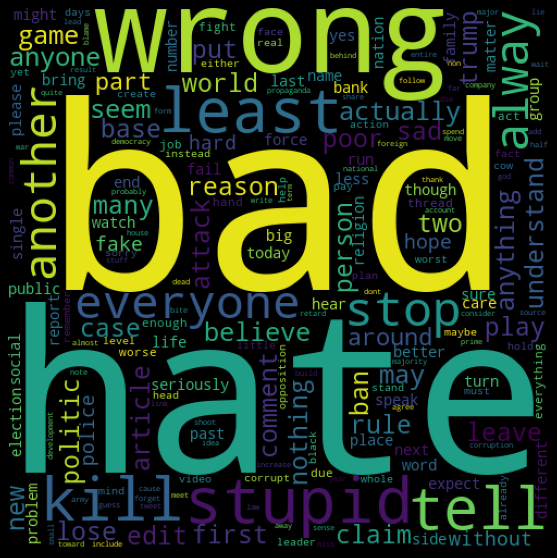

In [14]:
# Draw a comment image to show words with a high number of repetitions
comment_corpus = ' '.join(list(comment_final[comment_final['category'] == -1]['clean_comment']))
comment_wc = WordCloud(width = 500,height = 500).generate(comment_corpus)
plt.figure(figsize = (10, 10), facecolor = 'k')
plt.imshow(comment_wc)
plt.axis('off')
plt.show()

## model

In [15]:
# Start to build the model
X = comment_final.iloc[:,:-1]
y = comment_final.iloc[:,-1]
X

,clean_comment
0,family mormon explain stare puzzle kind strang...
2,seriously first complex explain normal anyway ...
4,benefit may might subsequent love easier able ...
5,sit together watch episode season episode litt...
8,two dogmatic dwell word conservative heart spi...
...,...
37230,nice
37233,part series minute focus different please pres...
37240,nice shock effect night demonetization
37243,agree push either pity course punish send hell


In [16]:
y

0        1
2       -1
4        1
5       -1
8       -1
        ..
37230    1
37233    1
37240    1
37243   -1
37247    1
Name: category, Length: 16554, dtype: int64

In [17]:
# Choose 10% as the test data, and the rest as the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
vectorizer = TfidfVectorizer()
X_train_matrix = vectorizer.fit_transform(X_train['clean_comment'])
features = vectorizer.get_feature_names()
comments_tfidf_df = pd.DataFrame(X_train_matrix.toarray(), columns=features)
comments_tfidf_df

,aam,abandon,abandonment,abatement,abbas,abbasi,abbot,abbreviation,abdicate,abduct,...,zealous,zee,zero,zimbabwe,zinc,zip,zombie,zonal,zone,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14896,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# using Logistic Regression
Logi_model = LogisticRegression(random_state=42)
Logi_model.fit(X_train_matrix, y_train)

LogisticRegression(random_state=42)

accuracy 0.79


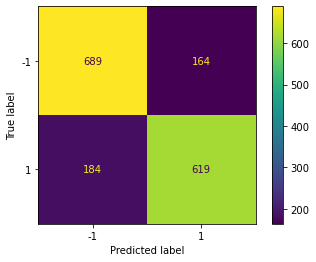

In [19]:
# Calculate the prediction accuracy of the model
X_test_matrix = vectorizer.transform(X_test['clean_comment'])
y_pred = Logi_model.predict(X_test_matrix)
plot_confusion_matrix(Logi_model, X_test_matrix, y_test) 
cf_matrix = confusion_matrix(y_test, y_pred)
accuracy  = np.round(np.trace(cf_matrix) / float(np.sum(cf_matrix)), 2)
print('accuracy', accuracy)

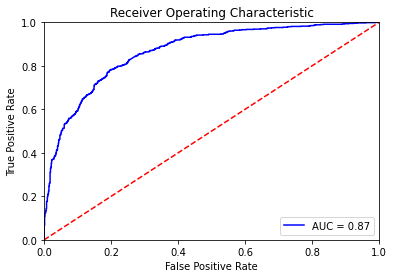

In [20]:
# calculate the fpr and tpr for all thresholds of the classification
probs = Logi_model.predict_proba(X_test_matrix)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [21]:
# # using Naive Bayes
NB_model = GaussianNB()
NB_model.fit(X_train_matrix.todense(), y_train)

GaussianNB()

accuracy 0.57


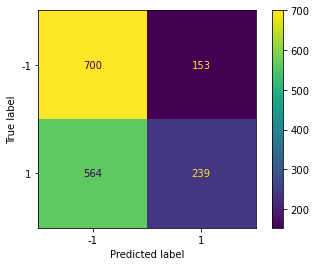

In [22]:
# Calculate the prediction accuracy of the model
X_test_matrix = vectorizer.transform(X_test['clean_comment'])
y_pred = NB_model.predict(X_test_matrix.todense())
plot_confusion_matrix(NB_model, X_test_matrix.todense(), y_test) 
cf_matrix = confusion_matrix(y_test, y_pred)
accuracy  = np.round(np.trace(cf_matrix) / float(np.sum(cf_matrix)), 2)
print('accuracy', accuracy)

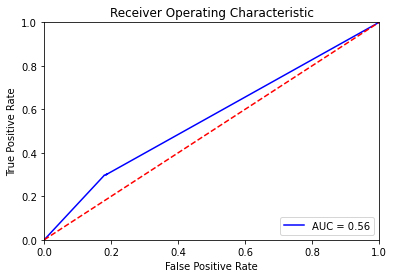

In [23]:
# calculate the fpr and tpr for all thresholds of the classification
probs = NB_model.predict_proba(X_test_matrix.todense())
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()